In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

# Global Variables

In [3]:
data_path = './data/'
devices = ['Pixel3-W', 'GalaxyJ7-W', 'Nexus5X-W', 'NokiaLong-W', 'NokiaRound-W']
batch_dict = json.load(open('batches.json', 'r'))
experiments = [0, 1, 10, 100, 1000]
boxplot_label_order = ['Accelerometer', 'Ambient Light', 'Baseline', 
             'Camera Low Frequency', 'Camera Medium Frequency', 'Camera High Frequency', 
             'Cpu Low Frequency', 'Cpu Medium Frequency', 'Cpu High Frequency', 
             'Display', 
             'GPS Low Frequency', 'GPS Medium Frequency', 'GPS High Frequency', 
             'Gyroscope',
             'Local Storage Low Frequency', 'Local Storage Medium Frequency', 'Local Storage High Frequency', 
             'Magnetic Field', 'Microphone', 
             'Networking Low Frequency', 'Networking Medium Frequency', 'Networking High Frequency', 
             'Room Database Low Frequency', 'Room Database Medium Frequency', 'Room Database High Frequency',
             'Speaker', 'Gravity', 
             'Cpu INTERVAL', 'Camera INTERVAL', 'Display INTERVAL']

# CSV Retrieval

In [5]:
def create_dirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

def get_aggregated_data(device, experiment, batch):
    path = os.path.join(data_path, device, f'Experiment{experiment}', batch, 'output')
    experiment_date = os.listdir(path)[-1]
    path = os.path.join(path, experiment_date, 'Aggregated_Results_Batterymanager.csv')
    df = pd.read_csv(os.path.join(path))
    subjects = df['subject'].unique()
    for subject in subjects:
        df['subject'] = df['subject'].replace(subject, batch_dict[batch][subject])
    
    if device == 'GalaxyJ7-W':  # GalaxyJ7-W is in mJ for some reason, I'm guessing it's due to the old BatteryManager API
        df['Energy trapz (J)'] = df['Energy trapz (J)'] * 1000
        df['Energy simple (J)'] = df['Energy simple (J)'] * 1000
        df['Avg power (W)'] = df['Avg power (W)'] * 1000

    df['Experiment'] = experiment
    return df

def concat_dataframes(device, experiment):
    df = pd.DataFrame()
    for batch in batch_dict:
        df = pd.concat([df, get_aggregated_data(device, experiment, batch)])
    return df

def get_baseline_median(df):
    return df[df['subject'] == 'Baseline']['Energy trapz (J)'].median()

# Visualisation

## Individual Boxplots

In [ ]:
def individual_boxplots(device, experiment, metric):
    df = concat_dataframes(device, experiment)
    plt.figure(figsize=(15, 10))
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x="subject", y=metric, data=df, showmeans=True, order=boxplot_label_order)
    ax.axhline(get_baseline_median(df), ls='--', color='red', label='Baseline Median')

    plt.xticks(rotation = 90)
    plt.gcf().subplots_adjust(bottom=0.25)
    plt.grid(True)

    plt.ylim(0, 380)
    plt.xlabel('Subject')
    plt.ylabel(metric)
    ax.set_title(f'{device} Experiment {experiment} {metric}')

    create_dirs(f'out/boxplots/{device}')
    
    return ax
    # plt.savefig(f'out/boxplots/{device}/experiment_{experiment}_{metric}.pdf', format="pdf")
    # plt.show()

for device in devices:
    for experiment in experiments:
        ax = individual_boxplots(device, experiment, 'Energy trapz (J)')
        plt.savefig(f'out/boxplots/{device}/experiment_{experiment}_Energy trapz (J).pdf', format="pdf")
        plt.show()

## Grouped Boxplots

In [ ]:
def all_boxplots(metric):
    fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(50, 50))

    for i, device in enumerate(devices):
        for j, experiment in enumerate(experiments):
            df = concat_dataframes(device, experiment)
            sns.set_theme(style="whitegrid")
            sns.boxplot(ax=axs[i, j], x="subject", y=metric, data=df, showmeans=True, order=boxplot_label_order)
            axs[i, j].axhline(get_baseline_median(df), ls='--', color='red', label='Baseline Median')
            axs[i, j].set_title(f'{device} Experiment {experiment} {metric}')

            axs[i, j].label_outer()
            axs[i, j].set_xticklabels(boxplot_label_order, rotation = 90)
            axs[i, j].set_xlabel('Subject')
            axs[i, j].set_ylabel(metric)        
            axs[i, j].grid(True)        

    fig.tight_layout()

    plt.savefig(f'out/boxplots/all_c_experiment_r_device{metric}.pdf', format="pdf")
    plt.show()



all_boxplots('Energy trapz (J)')

## Energy comparison of Experiments

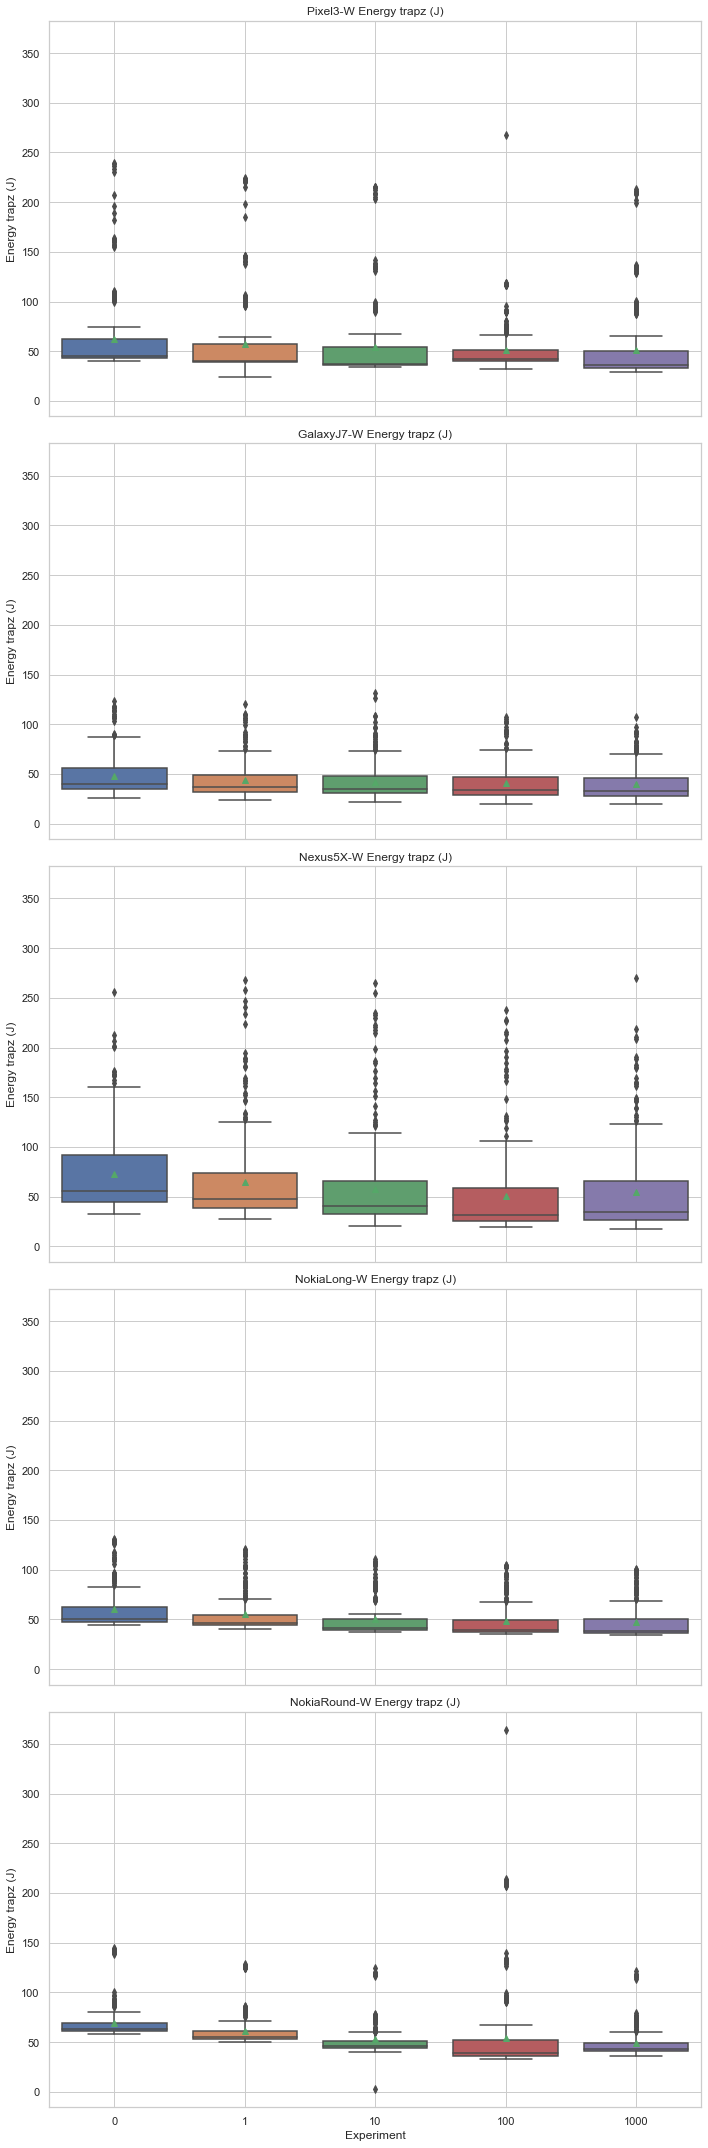

In [16]:
def experiment_boxplots(metric):
    # return df

    fig, axs = plt.subplots(5, 1, sharex=True, sharey=True, figsize=(10, 30))

    for i, device in enumerate(devices):
        df = pd.DataFrame()
        for experiment in experiments:
            df_tmp = concat_dataframes(device, experiment)
            df = pd.concat([df, df_tmp])

        sns.set_theme(style="whitegrid")
        sns.boxplot(ax=axs[i], x="Experiment", y=metric, data=df, showmeans=True, order=experiments)
        axs[i].set_title(f'{device} {metric}')

        axs[i].label_outer()
        axs[i].set_ylabel(metric)        
        axs[i].grid(True)

    fig.tight_layout()
    plt.savefig(f'out/boxplots/experiments_overview_{metric}.pdf', format="pdf")
    plt.show()

experiment_boxplots('Energy trapz (J)')